# Comparing the connectivity matrices from experimental data with theoretical predictions

The networks from Ioannis's paper have 4 populations of neurons - 3 excitatory (PEG, PEN, EPG) and 1 inhibitory (Delta7) while the theoretical work assumes only a single population of neurons that can have both excitatory and inhibitory connections.

Therefore, we simplify the connections in the 4-population network to produce an equivalent 1-population network so we can compare our predictions to the experimental results. This process is:
* considering the EPG neurons as the basis of the network, as they are in the ellipsoid body in the fly (ie. the ring)
* counting the number of paths through the 4 population that link 2 EPG neurons, and keeping track of the signs of these paths
* creating a new network of just EPG neurons with these same connections, weighted inversely depending on the path length gives us an equivalent 1-population network

In [1]:
import networkx as nx
import connectivity_matrices
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.path
import matplotlib.font_manager
import scipy.linalg
import itertools
import functools

plt.style.use('seaborn-v0_8-notebook')
matplotlib.use('pgf')
%matplotlib inline
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text
plt.rc('figure', facecolor = 'white') # otherwise background is transparent?

In [2]:
neuron_colours = {
	'EPG': '#eaf304',
	'PEN': '#32d376',
	'PEG': '#f87a4a',
	'D7': '#51b1e3',
}
neuron_name_to_type = lambda name: name.split('_')[0] # PEN, PEG, EPG, D7
neuron_name_to_type_index = lambda name: ['PEN', 'PEG', 'EPG', 'D7'].index(neuron_name_to_type(name)) # 0, 1, 2, 3
neuron_name_to_side = lambda name: name.split('_')[1][0] # L or R
neuron_index_from_side_number = lambda side_number: side_number[1:] if side_number.startswith('L') or side_number.startswith('R') else side_number
neuron_name_to_index = lambda name: int(neuron_index_from_side_number(name.split('_')[1])) # 1, 2, ...
color_graph = lambda g: [neuron_colours[neuron_name_to_type(node)] for node in g.nodes]
color_edges = lambda g: [('#8888dd' if g.edges[edge]['weight'] < 0 else '#dd6666') for edge in g.edges]

neuron_names = [f'{type}_{n}' for type in ['PEN','PEG','EPG','D7'] for n in range(1,9)]
neuron_names_janelia = [connectivity_matrices.fly_janelia_one_sided_neuron_index_to_name(index) for index in range(connectivity_matrices.FLY_JANELIA_ONE_SIDED.CONNECTIVITY_MATRIX_SIZE)]
EPG_neuron_indices = np.where([name.startswith('EPG') for name in neuron_names])[0]
EPG_neuron_indices_janelia = np.where([name.startswith('EPG') for name in neuron_names_janelia])[0]
cos_sin = lambda angle: np.array([np.cos(angle), np.sin(angle)])
neuron_type_magnitude = lambda name: [1.7, 1.7, 2.2, 1.2][neuron_name_to_type_index(name)] # PEN, PEG, EPG, D7
neuron_type_phase = lambda name: [0.75, 1.25, 1, 1][neuron_name_to_type_index(name)] # PEN, PEG, EPG, D7
neuron_pos = {name: neuron_type_magnitude(name)*cos_sin(2*np.pi*(neuron_name_to_index(name)+neuron_type_phase(name))/8) for name in neuron_names}

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real
circular_concat = lambda x : np.hstack((x, x[0]))

N = 8
neuron_indices = np.arange(N)

In [3]:
# graph drawing

def draw_recurrent_edges(ax, edges, weights, positions, scale=1.0, **kwargs):
	def _connectionstyle(posA, posB, *args, **kwargs):
		# Copied from NetworkX plotting code - modified to look nicer
		assert np.all(posA == posB), ValueError('Start and end positions of recurrent edge don\'t match')
		data_loc = posA
		v_shift = 18*scale
		h_shift = v_shift * 0.5
		# put the top of the loop first so arrow is not hidden by node
		path = [
			# 1
			data_loc + np.asarray([0, v_shift]),
			# 4 4 4
			data_loc + np.asarray([h_shift, v_shift]),
			data_loc + np.asarray([h_shift, 0]),
			data_loc,
			# 4 4 4
			data_loc + np.asarray([-h_shift, 0]),
			data_loc + np.asarray([-h_shift, v_shift]),
			data_loc + np.asarray([0, v_shift]),
		]
		return matplotlib.path.Path(path, [1, 4, 4, 4, 4, 4, 4])

	for edge, weight in zip(edges, weights):
		pos = positions[edge[0]]

		arrow = matplotlib.patches.FancyArrowPatch(
			pos,
			pos,
			connectionstyle=_connectionstyle,
			linewidth=weight,
			**kwargs
		)
		ax.add_patch(arrow)

def draw_graph(g, ax=None, small_nodes=False):
	if ax is None:
		ax = plt.gca()
	pos = nx.get_node_attributes(g, 'pos')
	node_colours = color_graph(g)
	weights = np.array(list(nx.get_edge_attributes(g, 'weight').values())) / 2
	edges = np.array(g.edges)
	bidirectional_edges = np.array([(edge[::-1] in list(g.edges) or (edge[1],edge[0],0) in list(g.edges)) for edge in list(g.edges)])
	PEN_EPG_edges = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[0]) != neuron_name_to_index(edge[1])) for edge in list(g.edges)])
	PEN_EPG_edges_next = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[0])%8 == (1+neuron_name_to_index(edge[1]))%8) for edge in list(g.edges)])
	PEN_EPG_edges_prev = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[1])%8 == (1+neuron_name_to_index(edge[0]))%8) for edge in list(g.edges)])
	recurrent_connections = np.array([edge[0] == edge[1] for edge in list(g.edges)])
	if small_nodes:
		node_size=150
		nx.draw_networkx_nodes(g, ax=ax, pos=pos, node_size=node_size, alpha=1.0, node_color=node_colours, edgecolors='black')
		nx.draw_networkx_labels(g, ax=ax, pos=pos, font_size=8, labels={node: f'${{{neuron_name_to_index(node)}}}$' for node in g.nodes})
	else:
		node_size=500
		nx.draw_networkx_nodes(g, ax=ax, pos=pos, node_size=node_size, alpha=1.0, node_color=node_colours, edgecolors='black')
		nx.draw_networkx_labels(g, ax=ax, pos=pos, font_size=8, labels={node: f'{neuron_name_to_type(node)}${{}}_{{{neuron_name_to_index(node)}}}$' for node in g.nodes})
	if len(edges):
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[(weights > 0) & bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], width=weights[(weights > 0) & bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], connectionstyle="arc3,rad=0.15", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[(weights > 0) & ~bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], width=weights[(weights > 0) & ~bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], connectionstyle="arc3,rad=0", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[PEN_EPG_edges_next], width=weights[PEN_EPG_edges_next], connectionstyle="arc3,rad=-0.2", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[PEN_EPG_edges_prev], width=weights[PEN_EPG_edges_prev], connectionstyle="arc3,rad=0.2", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#3333dd', edgelist=edges[(weights < 0) & bidirectional_edges & ~recurrent_connections], width=-weights[(weights < 0) & bidirectional_edges & ~recurrent_connections], connectionstyle="arc3,rad=0.05", arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=0.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#3333dd', edgelist=edges[(weights < 0) & ~bidirectional_edges & ~recurrent_connections], width=-weights[(weights < 0) & ~bidirectional_edges & ~recurrent_connections], connectionstyle="arc3,rad=0", arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=0.15))
	
		# Need to override NetworkX's recurrent loop plotting because the scaling is broken...
		draw_recurrent_edges(ax, edges[(weights < 0) & recurrent_connections], -weights[(weights < 0) & recurrent_connections], pos, scale=0.5 if small_nodes else 1.0, color='#3333dd', arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=2))
		draw_recurrent_edges(ax, edges[(weights > 0) & recurrent_connections], weights[(weights > 0) & recurrent_connections], pos, scale=0.5 if small_nodes else 1.0, color='#dd3333', arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=2, head_width=2))
	
	ax.axis('off')
	ax.axis('equal')

get_graph_edges = lambda M: [(neuron_names[pre],neuron_names[post], {'weight': M[pre,post]}) for pre in range(len(neuron_names)) for post in range(len(neuron_names)) if M[pre,post] != 0]
get_graph_edges_janelia = lambda M: [(neuron_names_janelia[pre],neuron_names_janelia[post], {'weight': M[pre,post]}) for pre in range(len(neuron_names_janelia)) for post in range(len(neuron_names_janelia)) if M[pre,post] != 0]
subset_graph_edges_EPG1 = lambda edges: [(pre,post,weight) for pre,post,weight in edges if pre == 'EPG_1' and post.startswith('EPG')]
subset_graph_edges_EPG = lambda edges: [(pre,post,weight) for pre,post,weight in edges if pre.startswith('EPG') and post.startswith('EPG')]
make_graph_from_matrix = lambda M: nx.DiGraph([(neuron_names[pre],neuron_names[post], {'weight': M[pre,post]}) for pre in range(32) for post in range(32) if M[pre,post] != 0])

def get_graph_paths_with_length(M, l, janelia=False):
	edge_list = []

	for connections in itertools.product([M * (M > 0),M * (M < 0)], repeat=l):
		connectivity_matrix = connections[0]
		if l > 1:
			for next_m in connections[1:]:
				if janelia:
					EPG_neurons_slice = slice(EPG_neuron_indices_janelia[0], EPG_neuron_indices_janelia[-1]+1)
				else:
					EPG_neurons_slice = slice(EPG_neuron_indices[0], EPG_neuron_indices[-1]+1)
				connectivity_matrix[EPG_neurons_slice,EPG_neurons_slice] = 0 # terminate all the paths that have reached an EPG neuron already
				connectivity_matrix = connectivity_matrix @ next_m
		# edges = get_graph_edges(functools.reduce(np.matmul, connections))
		edges = get_graph_edges_janelia(connectivity_matrix) if janelia else get_graph_edges(connectivity_matrix)
		edge_list += subset_graph_edges_EPG(edges)
	return edge_list

def plot_graph_simplification(M, path_lengths, axs):
	full_graph = make_graph_from_matrix(M)
	combined_edges = []
	path_length_graphs = []
	for path_length in path_lengths:
		edges = get_graph_paths_with_length(M, path_length)
		graph = nx.MultiDiGraph(edges)
		combined_edges += edges
		path_length_graphs.append(graph)
	combined_graph = nx.MultiDiGraph(combined_edges)

	for n, graph in enumerate([full_graph, *path_length_graphs, combined_graph]):
		nx.set_node_attributes(graph, neuron_pos, name='pos')
		draw_graph(graph, axs[n], small_nodes=n>0 and n<len(axs)-1)
	axs[0].set_title('Initial connectivity')
	axs[-1].set_title('Simplified connectivity')
	for n, path_length in enumerate(path_lengths):
		axs[n+1].set_title(f'Paths of length {path_length}')
		axs[n+1].set_xlim([axs[1].get_xlim()[0]-0.1, axs[1].get_xlim()[1]+0.1])

	return combined_graph

# going from graph to connectivity matrix profile
def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, plot_all_profiles=False, roll=False, show=True):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	if plot_all_profiles:
		unrolled_matrix = roll_matrix_rows(matrix, (matrix.shape[0]//2 if roll else 0) - np.arange(matrix.shape[0]))
		plt.plot(N, np.vstack((unrolled_matrix.T, unrolled_matrix.T[:,0])), 'k', alpha=0.2)

	plt.plot(N, circular_concat(mu), 'o--', markersize=6, linewidth=1)
	if plot_stddev:
		plt.fill_between(N, circular_concat(mu-stddev), circular_concat(mu+stddev), alpha=0.2)
	if show:
		plt.show()
	return mu

def graph_to_connectivity_matrix(g, nodes):
	connectivity_matrix = np.zeros((len(nodes),len(nodes)))

	for edge,weight in nx.get_edge_attributes(g, 'weight').items():
		connectivity_matrix[nodes.index(edge[0]),nodes.index(edge[1])] += weight
	return connectivity_matrix

def profile_to_mu_amp_phase(profile):
	# using vector population code readout
	# first remove the mean, then array the profile around a circle and find the angle and vector magnitude
	# for a sinusoid of amplitude 1, the total length will be 4 (2 + 4(sqrt(2)/2)^2), so normalise by this
	mu = profile.mean()
	x = np.sum((profile - mu) * np.cos(2*np.pi*np.arange(len(profile))/len(profile)))
	y = np.sum((profile - mu) * np.sin(2*np.pi*np.arange(len(profile))/len(profile)))
	return mu, np.sqrt(x**2 + y**2)/4, len(profile)/(2*np.pi)*np.arctan2(y, x)

## Visualising the theoretical networks with different harmonics

For each network that uses a single harmonic, we visualise its connectivity graph

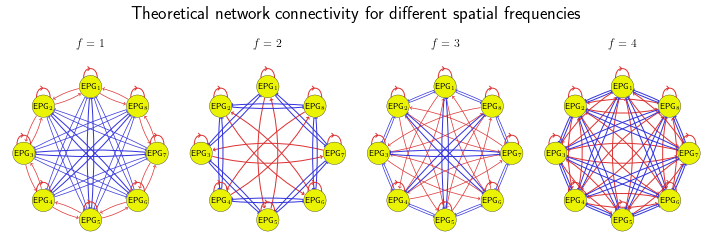

In [4]:
f_range = range(1,5)
fig,axs = plt.subplots(1, len(f_range), figsize=(10,3.5))
for i, f in enumerate(f_range):
	W = profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N))
	edges = [(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6]
	g = nx.DiGraph(edges)
	nx.set_node_attributes(g, neuron_pos, name='pos')
	draw_graph(g, axs[i])
	axs[i].set_title(f'$f={f}$')

plt.suptitle('Theoretical network connectivity for different spatial frequencies', fontsize=18)
plt.tight_layout()
plt.savefig('plots/theoretical-network-graphs.pgf')
plt.savefig('plots/theoretical-network-graphs.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(3,3))
f=1
W = profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N))
edges = [(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6]
g = nx.DiGraph(edges)
nx.set_node_attributes(g, neuron_pos, name='pos')
draw_graph(g)
plt.tight_layout()
plt.savefig('plots/theoretical-network-graph-f1.pgf')
plt.show()

Interestingly, 
* the $f=2$ network is actually two independent disconnected networks - $[1,3,5,7]$ and $[2,4,6,8]$
* counting the connections to and from each neurons, we see that the $f=1$ and $f=3$ networks are the same

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(10,4))

f = 1
g = (lambda W: nx.DiGraph([(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6])) \
		(profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N)))
nx.set_node_attributes(g, neuron_pos, name='pos')
draw_graph(g, axs[0])
axs[0].set_title(f'$f={f}$')

f = 3
g = (lambda W: nx.DiGraph([(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6])) \
		(profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N)))
nx.set_node_attributes(g, neuron_pos, name='pos')
draw_graph(g, axs[1])
axs[1].set_title(f'$f={f}$ (original)')

nx.set_node_attributes(g, {name: neuron_type_magnitude(name)*cos_sin(2*np.pi*([1,4,7,2,5,8,3,6][neuron_name_to_index(name)-1]+neuron_type_phase(name))/8) for name in neuron_names}, name='pos')
draw_graph(g, axs[2])
axs[2].set_title(f'$f={f}$ (permuted)')
plt.suptitle('Theoretical network connectivity is the same for $f=1$ and $f=3$ after permuting neuron identities', fontsize=18)
plt.tight_layout()
plt.savefig('plots/theoretical-network-f1-f3-same.pgf')
plt.savefig('plots/theoretical-network-f1-f3-same.pdf')
plt.show()

Permuting the neurons indices clearly shows the correspondence between the $f=1$ and $f=3$ networks

## Simplifying the experimental networks

Starting with the networks from Ioannis's paper for the fly and locust, we simplify them from 4 populations to 1 population by calculating the "effective connectivity" between pairs of EPG neurons in the network for path lengths greater than 1.

This gives us simplified 1 populations networks we can compare to the theoretical predictions

In [5]:
locust_g = nx.DiGraph(connectivity_matrices.get_locust_simplified_connectivity_matrix_edge_list())
nx.set_node_attributes(locust_g, neuron_pos, name='pos')

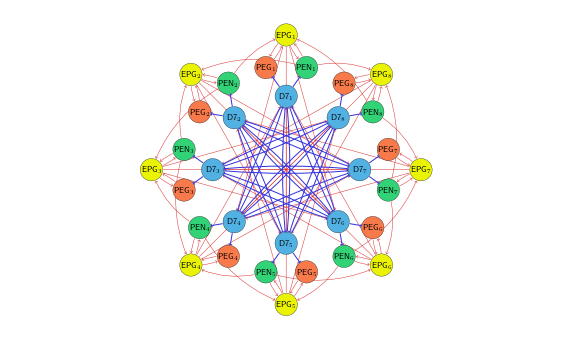

In [10]:
draw_graph(locust_g)

In [104]:
def get_all_non_repeating_paths(n_from:str, n_to:str, max_length:int):
	if n_from == n_to:
		parents = [pre for pre,post in locust_g.edges() if post == n_to]
		paths = [p+[n_to] for p in nx.all_simple_paths(locust_g, n_from, parents, max_length) if np.all([not n.startswith('EPG') for n in p[1:-1]])]
	else:
		paths = [p for p in nx.all_simple_paths(locust_g, n_from, n_to, max_length) if np.all([not n.startswith('EPG') for n in p[1:-1]])]
	return paths

path_lengths = lambda paths: [len(p)-1 for p in paths]
path_signs = lambda paths: [np.prod([-1 if n.startswith('D7') else 1 for n in p]) for p in paths]

In [118]:
sums = []
# for n in range(1,9):
# 	paths = get_all_non_repeating_paths(f'EPG_4', f'EPG_{n}', 10)
# 	lengths = path_lengths(paths)
# 	signs = path_signs(paths)
# 	sums.append(np.sum(signs))

for max_length in range(4,11):
	sums.append([np.sum(path_signs(get_all_non_repeating_paths(f'EPG_4', f'EPG_{n}', max_length))) for n in range(1,9)])

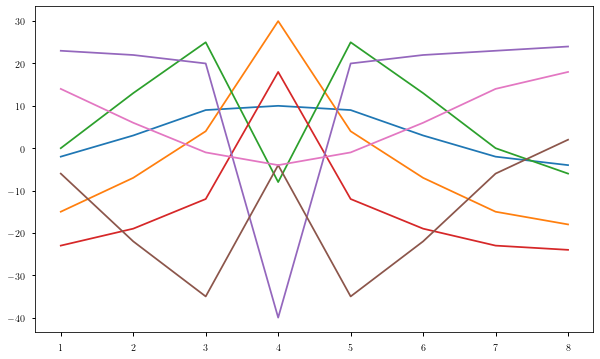

In [121]:
plt.plot(range(1,9), np.array(sums).T)
# mean,amp,phase = profile_to_mu_amp_phase(np.array(sums))
# plt.plot(mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)

### Locust

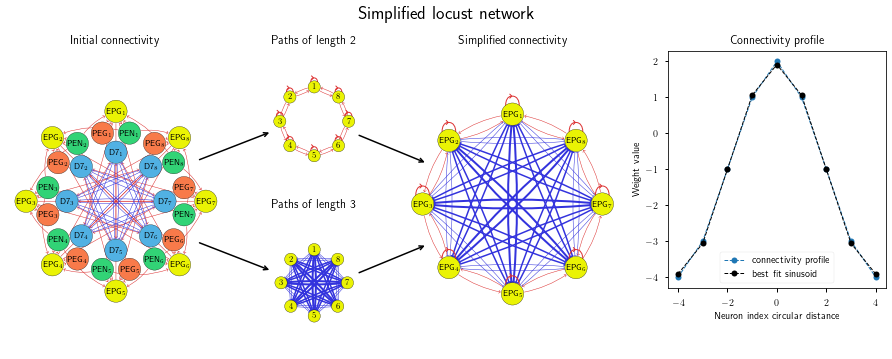

In [11]:
M_locust = connectivity_matrices.get_locust_simplified_connectivity_matrix_raw()

fig, axs = plt.subplot_mosaic("AABEEFF;AACEEFF", figsize=(12.5,5.5))
# fig, axs = plt.subplot_mosaic("AABEE;AACEE;AADEE", figsize=(10,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D
simplified_graph_locust = plot_graph_simplification(M_locust, [2,3], axs[:4])

simplified_connectivity_matrix_locust = graph_to_connectivity_matrix(simplified_graph_locust, sorted(list(simplified_graph_locust.nodes)))
plt.sca(axs[-1])
weight_profile_locust = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_locust, plot_stddev=False, roll=True, show=False)
mean, amp, _ = profile_to_mu_amp_phase(weight_profile_locust)

axs[-1].plot(np.arange(-N//2,N//2+1), mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)
axs[-1].legend(['connectivity profile','best fit sinusoid'])
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Weight value')
axs[-1].set_title('Connectivity profile')

plt.suptitle('Simplified locust network', fontsize=18)
plt.tight_layout()

# get the bottom of the axis label to match the bottom of the graph plots
axpos = axs[-1].get_position()
axpos.y0 = 0.27
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(3.8,1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(3.8,-1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-3.8,1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-3.8,-1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

plt.savefig('plots/network-graph-simplified-locust.png')
plt.show()

In [ ]:
fig, axs = plt.subplot_mosaic("AABDD;AACDD", figsize=(10,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D
simplified_graph_locust = plot_graph_simplification(M_locust, axs)
plt.suptitle('Locust network', fontsize=21)
for i in range(4):
	axs[i].set_title(axs[i].get_title(), fontsize=16)
plt.tight_layout()
axs[0].annotate('', xy=(2.0,1), xytext=(2.8,1.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(2.8,-1.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[3].annotate('', xy=(-2.1,1), xytext=(-2.8,1.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[3].annotate('', xy=(-2.1,-1), xytext=(-2.8,-1.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
plt.savefig('plots/network-graph-simplified-locust.pgf')
plt.show()

The locust network matches very closely the $f=1$ theoretical network, the only difference being the addition of some very weak inhibitory connections between neurons 90 degrees apart in the ring (eg. $\text{EPG}_1 \to \text{D7}_4 \to \text{PEN}_4 \to \text{EPG}_3$)

We can visualise the connectvity profile to confirm this

In [ ]:
simplified_connectivity_matrix_locust = graph_to_connectivity_matrix(simplified_graph_locust, sorted(list(simplified_graph_locust.nodes)))
weight_profile_locust = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_locust, plot_stddev=False, roll=True, show=False)
mean, amp, _ = profile_to_mu_amp_phase(weight_profile_locust)

plt.plot(np.arange(-N//2,N//2+1), mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)
plt.legend(['connectivity profile','best fit sinusoid'])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Simplified graph connectivity profile for locust')
plt.savefig('plots/simplified-connectivity-profile-locust.pdf')
plt.show()

### Fruit fly

In [ ]:
M_fly = connectivity_matrices.get_fly_simplified_connectivity_matrix_raw()

fig, axs = plt.subplot_mosaic("AABDD;AACDD", figsize=(10,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D
simplified_graph_fly = plot_graph_simplification(M_fly, [2,3], axs)
plt.suptitle('Fly network', fontsize=18)
plt.tight_layout()
plt.savefig('plots/network-graph-simplified-fly.pdf')
plt.show()

In [ ]:
fig, axs = plt.subplot_mosaic("AABDD;AACDD", figsize=(10,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D
simplified_graph_locust = plot_graph_simplification(M_fly, axs)
plt.suptitle('Fly network', fontsize=21)
for i in range(4):
	axs[i].set_title(axs[i].get_title(), fontsize=16)
axs[0].annotate('', xy=(2.0,1), xytext=(2.8,1.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(2.8,-1.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[3].annotate('', xy=(-2.1,1), xytext=(-2.8,1.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[3].annotate('', xy=(-2.1,-1), xytext=(-2.8,-1.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
plt.tight_layout()
plt.savefig('plots/network-graph-simplified-fly.pgf')
plt.show()

The fly network is structured somewhat similarly to the $f=1$ theoretical network in its excitatory connectivity, but the global inhibition of the fly network isn't consistent with the theoretical model.

Looking at the connectivity profile we see that the profile is not sinusoidal (assuming all synapses have equal strength)

In [ ]:
simplified_connectivity_matrix_fly = graph_to_connectivity_matrix(simplified_graph_fly, sorted(list(simplified_graph_fly.nodes)))
weight_profile_fly = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly, plot_stddev=False, roll=True, show=False)
mean, amp, _ = profile_to_mu_amp_phase(weight_profile_fly)

plt.plot(np.arange(-N//2,N//2+1), mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)
plt.legend(['connectivity profile','best fit sinusoid'])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Simplified graph connectivity profile for fly')
plt.savefig('plots/simplified-connectivity-profile-fly.pdf')
plt.show()

### Fly (Janelia connectome)

Looking at the connectivity derived from the Janelia connectome (and roughly scaling the synapse counts down)

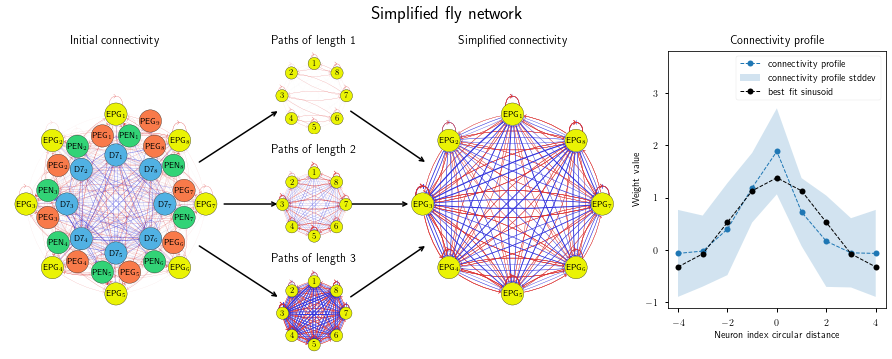

In [12]:
M_fly_janelia = connectivity_matrices.get_fly_janelia_one_sided_connectivity_matrix_raw() / 1000
M_fly_janelia[connectivity_matrices.FLY_JANELIA_ONE_SIDED.SLICE_D7,:] = -M_fly_janelia[connectivity_matrices.FLY_JANELIA_ONE_SIDED.SLICE_D7,:]

# fig, axs = plt.subplot_mosaic("AABDD;AACDD", figsize=(10,5))
fig, axs = plt.subplot_mosaic("AABFFGG;AACFFGG;AADFFGG", figsize=(12.5,5.5))
# fig, axs = plt.subplot_mosaic("AABFF;AACFF;AADFF;AAEFF", figsize=(20,10))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D

M = M_fly_janelia
make_graph_from_matrix_janelia = lambda M: nx.DiGraph([(neuron_names_janelia[pre],neuron_names_janelia[post], {'weight': M[pre,post]}) \
	for pre in range(connectivity_matrices.FLY_JANELIA_ONE_SIDED.CONNECTIVITY_MATRIX_SIZE) \
	for post in range(connectivity_matrices.FLY_JANELIA_ONE_SIDED.CONNECTIVITY_MATRIX_SIZE) \
	if M[pre,post] != 0])
neuron_pos_janelia = {name: neuron_type_magnitude(name)*cos_sin(2*np.pi*(neuron_name_to_index(name)+neuron_type_phase(name))/8) for name in neuron_names_janelia}
neuron_pos_janelia['PEG_9'] = 2.2*cos_sin(2*np.pi*(8.5+1)/8) # position the extra PEG neuron

path_lengths = [1,2,3]

full_graph = make_graph_from_matrix_janelia(M)
combined_edges = []
path_length_graphs = []
for path_length in path_lengths:
	edges = get_graph_paths_with_length(M, path_length, janelia=True)
	graph = nx.MultiDiGraph(edges)
	combined_edges += edges
	path_length_graphs.append(graph)
combined_graph = nx.MultiDiGraph(combined_edges)

axs[0].set_title('Initial connectivity')
nx.set_node_attributes(full_graph, neuron_pos_janelia, name='pos')
draw_graph(full_graph, axs[0])

for n, graph in enumerate([*path_length_graphs]):
	nx.set_node_attributes(graph, neuron_pos_janelia, name='pos')
	draw_graph(graph, axs[n+1], small_nodes=True)

axs[-2].set_title('Simplified connectivity')
nx.set_node_attributes(combined_graph, neuron_pos_janelia, name='pos')
draw_graph(combined_graph, axs[-2])

for n, path_length in enumerate(path_lengths):
	axs[n+1].set_title(f'Paths of length {path_length}')
	axs[n+1].set_xlim([axs[1].get_xlim()[0]-0.1, axs[1].get_xlim()[1]+0.1])

# plot weight profile vs sinusoid
simplified_connectivity_matrix_fly_janelia = graph_to_connectivity_matrix(combined_graph, sorted(list(combined_graph.nodes)))
plt.sca(axs[-1])
weight_profile_fly_janelia = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly_janelia, plot_stddev=True, roll=True, show=False)
mean, amp, _ = profile_to_mu_amp_phase(weight_profile_fly_janelia)
axs[-1].plot(np.arange(-N//2,N//2+1), mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)
axs[-1].legend(['connectivity profile','connectivity profile stddev','best fit sinusoid'])
axs[-1].set_title('Connectivity profile')
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Weight value')
axs[-1].set_ylim(-1.1,3.8)

plt.suptitle('Simplified fly network', fontsize=18)
plt.tight_layout()

axpos = axs[-1].get_position()
axpos.y0 = 0.22
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(4.0,2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.6,0), xytext=(4.0,0), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(4.0,-2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-4.0,2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.5,0), xytext=(-4.0,0), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-4.0,-2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

# plt.savefig('plots/network-graph-simplified-janelia.pgf')
plt.savefig('plots/network-graph-simplified-janelia.png')
plt.show()

It's a bit hard to make out the resulting connectivity. Plotting the connectivity profile we see a very noisy profile that is approximately consistent with closer range excitation and longer range inhibition as expected.

In [ ]:
simplified_connectivity_matrix_fly_janelia = graph_to_connectivity_matrix(combined_graph, sorted(list(combined_graph.nodes)))
weight_profile_fly_janelia = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly_janelia, plot_stddev=True, roll=True, show=False)
mean, amp, _ = profile_to_mu_amp_phase(weight_profile_fly_janelia)

plt.plot(np.arange(-N//2,N//2+1), mean + amp*np.cos(2*np.pi*np.arange(-N//2,N//2+1)/N), 'ko--', markersize=6, linewidth=1)
plt.legend(['connectivity profile','connectivity profile stddev','best fit sinusoid'])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Simplified graph connectivity profile for fly from Janelia connectome')
plt.savefig('plots/simplified-connectivity-profile-janelia.pdf')
plt.show()

In [ ]:
half_profile = [weight_profile_fly_janelia[0], *((weight_profile_fly_janelia[1:4] + weight_profile_fly_janelia[-1:-4:-1])/2), weight_profile_fly_janelia[4]]
plt.plot(half_profile + half_profile[-2::-1])
# weight_profile_fly_janelia[-1:-4:-1]